In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=8e3ceb770fbd7855d259e2849904613439bc12cbed95b064d2d8e038c5e4ce45
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


47/47 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 2s 7ms/step
Cross-validation scores: [0.8221316933631897, 0.8349184989929199, 0.8430706262588501, 0.8254076242446899, 0.8349184989929199]
Mean cross-validation score: 0.8320893883705139


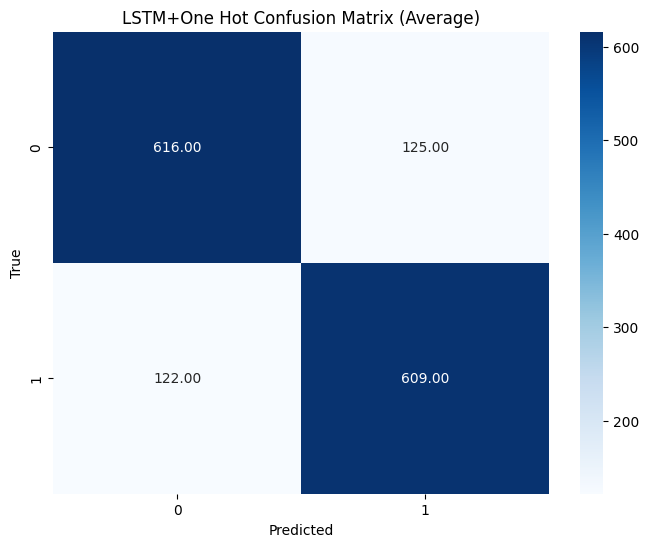


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3709
           1       0.83      0.83      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.83      0.83      0.83      7361
weighted avg       0.83      0.83      0.83      7361



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras_self_attention import SeqSelfAttention
import matplotlib.pyplot as plt
import seaborn as sns

# Önişleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'  # '?' ve '.' kaldırılmayacak
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()

    # Stop words'u kaldırma
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    text = ' '.join(words_filtered)

    return text

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)
xt['label'] = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(xt['label'])

# Tokenizer oluşturma
max_words = 10000  # En fazla 10,000 kelime
max_len = 100      # Her metin için maksimum uzunluk
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(xt['mesaj'])

# Metinleri sayılara dönüştürme
X_seq = tokenizer.texts_to_sequences(xt['mesaj'])

# Dizi uzunluğunu ayarlama
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Modeli oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(LSTM(128, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
conf_matrix_sum = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=np.float32)
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix hesaplama ve toplama
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    conf_matrix_sum += conf_matrix

    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

# Confusion matrix ortalaması

conf_matrix_avg = conf_matrix_sum / kfold.get_n_splits()

# Cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")
conf_matrix_avg = np.round(conf_matrix_sum / kfold.get_n_splits()).astype(int)
# Confusion matrix ortalamasını grafiksel olarak gösterme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM+One Hot Confusion Matrix (Average)')
plt.show()

# Classification report
target_names = [str(cls) for cls in np.unique(y_encoded)]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

In [ ]:
# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Kullanıcıdan metin girişi al ve sınıflandır
while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

Sınıflandırmak istediğiniz mesajı girin: aptal


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Tahmin: 1


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


47/47 [==============================] - 2s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 2s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 7ms/step
Cross-validation scores: [0.8431771993637085, 0.8274456262588501, 0.8226901888847351, 0.8369565010070801, 0.83423912525177]
Mean cross-validation score: 0.8329017281532287
Average Confusion Matrix:
[[613 129]
 [117 613]]


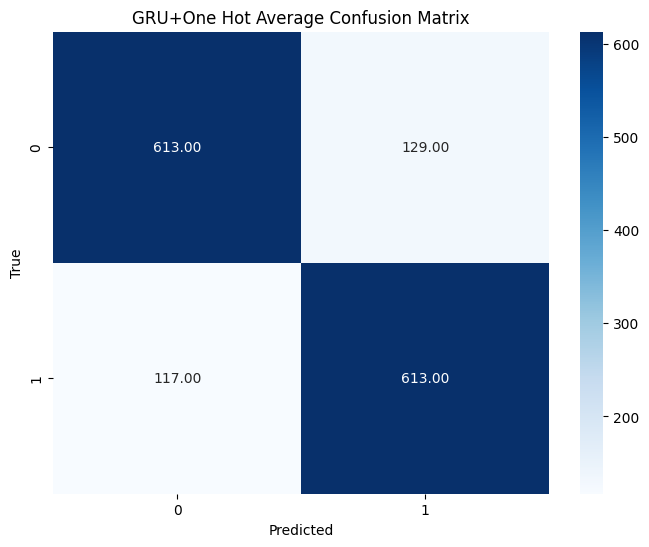


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3709
           1       0.83      0.84      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.83      0.83      0.83      7361
weighted avg       0.83      0.83      0.83      7361



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns

# Önişleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'  # '?' ve '.' kaldırılmayacak
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()

    # Stop words'u kaldırma
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    text = ' '.join(words_filtered)

    return text

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)
xt['label'] = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(xt['label'])

# Tokenizer oluşturma
max_words = 10000  # En fazla 10,000 kelime
max_len = 100      # Her metin için maksimum uzunluk
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(xt['mesaj'])

# Metinleri sayılara dönüştürme
X_seq = tokenizer.texts_to_sequences(xt['mesaj'])

# Dizi uzunluğunu ayarlama
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Modeli oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı eklendi
    model.add(Dropout(0.5))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_conf_matrices = []
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix for the test set
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    all_conf_matrices.append(conf_matrix)

    # Tahmin ve gerçek etiketleri birleştir
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")


# Average confusion matrix
avg_conf_matrix = np.round(np.mean(all_conf_matrices, axis=0)).astype(int)

print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Confusion matrix'i grafiksel olarak gösterme
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU+One Hot Average Confusion Matrix')
plt.show()

# Classification report
target_names = [str(cls) for cls in np.unique(y_encoded)]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

In [ ]:
# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Kullanıcıdan metin girişi al ve sınıflandır
while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): salak


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
Tahmin: 1


KeyboardInterrupt: Interrupted by user

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


47/47 [==============================] - 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 2s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 3s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 2s 9ms/step
Cross-validation scores: [0.8323150277137756, 0.829483687877655, 0.8430706262588501, 0.8226901888847351, 0.8457880616188049]
Mean cross-validation score: 0.8346695184707642
Average Confusion Matrix:
[[630 111]
 [132 598]]


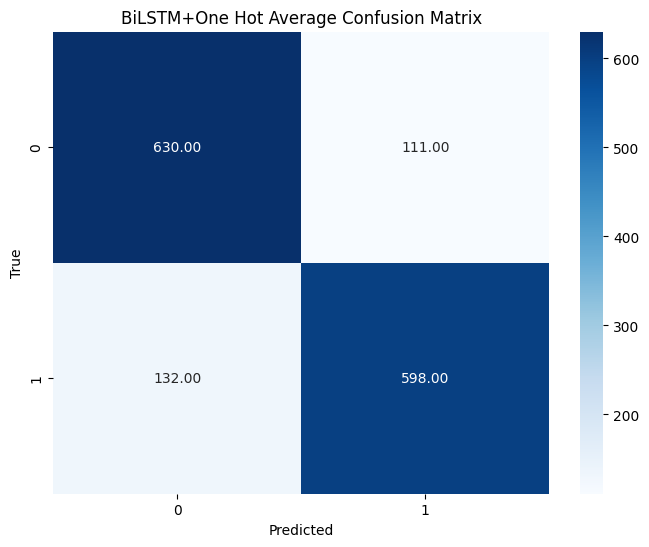


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3709
           1       0.84      0.82      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.83      0.83      0.83      7361
weighted avg       0.83      0.83      0.83      7361



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras_self_attention import SeqSelfAttention
import matplotlib.pyplot as plt
import seaborn as sns

# Önişleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'  # '?' ve '.' kaldırılmayacak
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()

    # Stop words'u kaldırma
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    text = ' '.join(words_filtered)

    return text

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)
xt['label'] = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(xt['label'])

# Tokenizer oluşturma
max_words = 10000  # En fazla 10,000 kelime
max_len = 100      # Her metin için maksimum uzunluk
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(xt['mesaj'])

# Metinleri sayılara dönüştürme
X_seq = tokenizer.texts_to_sequences(xt['mesaj'])

# Dizi uzunluğunu ayarlama
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Modeli oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # BiLSTM katmanı
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))  # BiLSTM katmanı
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_conf_matrices = []
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix for the test set
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    all_conf_matrices.append(conf_matrix)

    # Tahmin ve gerçek etiketleri birleştir
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Average confusion matrix
avg_conf_matrix = np.round(np.mean(all_conf_matrices, axis=0)).astype(int)
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Confusion matrix'i grafiksel olarak gösterme
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BiLSTM+One Hot Average Confusion Matrix')
plt.show()

# Classification report
target_names = [str(cls) for cls in np.unique(y_encoded)]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

In [ ]:
# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Kullanıcıdan metin girişi al ve sınıflandır
while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): eşek
1/1 [==============================] - 2s 2s/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): eşek
1/1 [==============================] - 0s 27ms/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): hayvan
1/1 [==============================] - 0s 38ms/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): q


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


47/47 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 0s 2ms/step
Cross-validation scores: [0.8336727619171143, 0.836277186870575, 0.8396739363670349, 0.8322010636329651, 0.8410326242446899]
Mean cross-validation score: 0.8365715146064758
Average Confusion Matrix:
[[626 116]
 [125 606]]


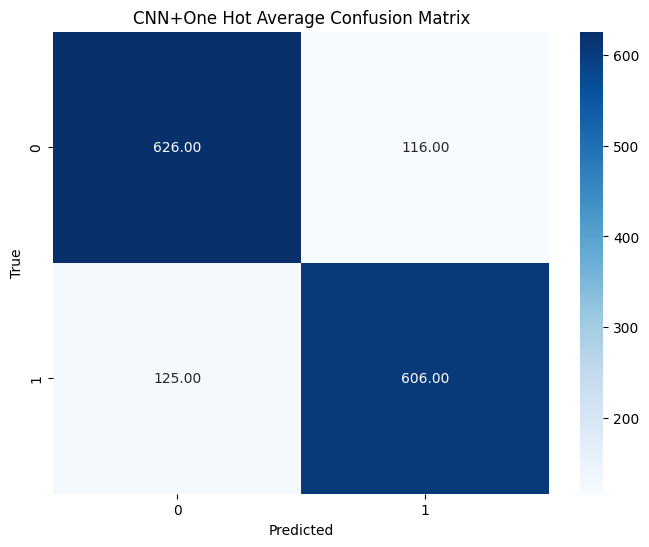


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      3709
           1       0.84      0.83      0.83      3652

    accuracy                           0.84      7361
   macro avg       0.84      0.84      0.84      7361
weighted avg       0.84      0.84      0.84      7361



In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
import matplotlib.pyplot as plt
import seaborn as sns

# Önişleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'  # '?' ve '.' kaldırılmayacak
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()

    # Stop words'u kaldırma
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    text = ' '.join(words_filtered)

    return text

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)
xt['label'] = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(xt['label'])

# Tokenizer oluşturma
max_words = 10000  # En fazla 10,000 kelime
max_len = 100      # Her metin için maksimum uzunluk
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(xt['mesaj'])

# Metinleri sayılara dönüştürme
X_seq = tokenizer.texts_to_sequences(xt['mesaj'])

# Dizi uzunluğunu ayarlama
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Modeli oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # Konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # Max pooling katmanı
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # İkinci konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # İkinci max pooling katmanı
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı
    model.add(GlobalMaxPooling1D())  # Global max pooling katmanı
    model.add(Dropout(0.5))  # Dropout katmanı
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_conf_matrices = []
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix for the test set
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    all_conf_matrices.append(conf_matrix)

    # Tahmin ve gerçek etiketleri birleştir
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Average confusion matrix
avg_conf_matrix = np.round(np.mean(all_conf_matrices, axis=0)).astype(int)
print("Average Confusion Matrix:")
print(avg_conf_matrix)

# Confusion matrix'i grafiksel olarak gösterme
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN+One Hot Average Confusion Matrix')
plt.show()

# Classification report
target_names = [str(cls) for cls in np.unique(y_encoded)]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

In [ ]:
# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Kullanıcıdan metin girişi al ve sınıflandır
while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): salak
1/1 [==============================] - 0s 180ms/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): eşek
1/1 [==============================] - 0s 22ms/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): hadi gel
1/1 [==============================] - 0s 21ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): q
